In [13]:
#-------------------------Imports---------------------------
import numpy as np
import pandas as pd

from pycbc.waveform import get_td_waveform
from pycbc import types, fft, waveform

from scipy.stats import uniform
from scipy import interpolate
from scipy.integrate import quad
from scipy import constants
from scipy.optimize import curve_fit

import os
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy import constants as astro_const

from multiprocessing import Pool
from multiprocessing import Process

from tqdm import tqdm

###########################
# CONSTANTS
###########################
H0GLOB= 67#67.9 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoglob = Planck18

cosmoeuclid = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value
h=H0/100

#geometrization of masses
Msun=(1.98892)*(10**30)
solarmass_to_m=(constants.G*Msun)/((constants.c)**2)#G/c^2
Mpc_to_m=3.08567758128*(10**22) #this will be used later

In [14]:
#-----------------Einstein Telescope Stuff------------------------------
#Antennas behave like an L-shaped interferometer but with sin(60°)
#There are 3 antennas, phi rotates each time
#The SNR is the square root of the sum of each SNR^2 

def ET_antenna_one_plus(cos_theta,phi,psi):
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.cos(2*psi)-B*np.sin(2*psi))
    return ret
def ET_antenna_one_cross(cos_theta,phi,psi):
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
def ET_antenna_two_plus(cos_theta,phi,psi):
    phi=phi+(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.cos(2*psi)-B*np.sin(2*psi))
    return ret
def ET_antenna_two_cross(cos_theta,phi,psi):
    phi=phi+(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
def ET_antenna_three_plus(cos_theta,phi,psi):
    phi=phi+(4*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.cos(2*psi)-B*np.sin(2*psi))
    return ret
def ET_antenna_three_cross(cos_theta,phi,psi):
    phi=phi+(4*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
#----function that perform the SNR-----------------
#---use this function in a loop, you must provide the angles for each ds
#read it from the EVA (catalogues) series.
def ET_SNR_Evaluation(ds_theta,ds_phi,ds_psi,hp,hc):
    temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
    temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
    first_prefactor=(ET_antenna_one_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_one_cross(ds_theta,ds_phi,ds_psi))**2
    firstSNR=(temp_plus+temp_cross)*first_prefactor*4
    second_prefactor=(ET_antenna_two_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_two_cross(ds_theta,ds_phi,ds_psi))**2
    secondSNR=(temp_plus+temp_cross)*second_prefactor*4
    third_prefactor=(ET_antenna_three_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_three_cross(ds_theta,ds_phi,ds_psi))**2
    thirdSNR=(temp_plus+temp_cross)*third_prefactor*4
    totSNR=np.sqrt(firstSNR+secondSNR+thirdSNR)
    return totSNR
def signal_noise_toint(f,signal):
    #numerator=((constant/dist)*(mass**(5/6))*(((1+cos**2)/2)**2)*f**(-7/6))**2
    numerator=(signal(f)**2)
    #numerator= (np.real(signal(f))**2)+(np.imag(signal(f))**2)
    denom=(ET_sn(f)**2)
    return (numerator/denom)

In [15]:
def Multi_SNR(i):
    lum_distance=(1+zz[i])*com_distance[i]
    fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1[i]+m2[i])*astro_const.M_sun.value)
    df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
    #FDhp,FDhc = waveform.get_fd_waveform(approximant="IMRPhenomD",
    #                           mass1=m1[i], mass2=m2[i],inclination=inclin[i],
    #                           distance=lum_distance[i],
    #                           spin1z=0,spin2z=0,  
    #                           delta_f=1.0/500,f_lower=0.5,f_final=0)
    FDhp,FDhc = waveform.get_fd_waveform(
                                         approximant="IMRPhenomD",
                                         mass1=m1[i], 
                                         mass2=m2[i],
                                         inclination=inclin[i],
                                         spin1z=0,
                                         spin2z=0,  
                                         distance=lum_distance,
                                         delta_f=df,
                                         f_lower=0.5,f_final=0
                                        )
    freq=np.array(FDhp.sample_frequencies)
    FDwfp = np.array(FDhp.data)[freq>=ET_min_freq]
    FDwfc = np.array(FDhc.data)[freq>=ET_min_freq]
    freq=freq[freq>=ET_min_freq]
    hp_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfp*(1+zz[i])**2),fill_value="extrapolate")
    hc_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfc*(1+zz[i])**2),fill_value="extrapolate")
    #hp_interpol=interpolate.interp1d(freq,abs(FDwfp**2),fill_value="extrapolate")
    #hc_interpol=interpolate.interp1d(freq,abs(FDwfc**2),fill_value="extrapolate")
    temp=ET_SNR_Evaluation(cos_theta[i],phi[i],psi[i],hp_interpol,hc_interpol)
    return temp

In [30]:
def phi_from_cart(x,y):
    if(x>0):
        phi=np.arctan(y/x)
    if ((x<0) and (y>=0)):
        phi=np.arctan(y/x)+np.pi
    if ((x<0) and (y<0)):
        phi=np.arctan(y/x)-np.pi
    return phi
def theta_from_cart(x,y,z):
    den=np.sqrt(x**2+y**2+z**2)
    theta=np.arccos(z/den)
    return theta

def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
def ra_from_phi(phi):
    ra = np.rad2deg(phi)
    return ra
def dec_from_theta(theta):
    dec = np.rad2deg(0.5 * np.pi - theta)
    return dec

In [36]:
#---------------Einstein Telescope Noise-----------------
ET_freq=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=0)
ET_noise=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=3)#This is the amplitude so must be squared
ET_sn=interpolate.interp1d(ET_freq,ET_noise,kind='cubic',fill_value="extrapolate")
ET_min_freq=ET_freq.min()
ET_max_freq=ET_freq.max()
print('Freq_min={}, Freq_max={}'.format(ET_min_freq,ET_max_freq))

Freq_min=1.0, Freq_max=10000.0


In [19]:
#------------read the flagship-------------------------------------
dat = Table.read('EVA02.fits', format='fits')
EVA = dat.to_pandas()#all good, is an only text fits
#EVA.head(3)
ds_x=EVA['DS_x']
ds_y=EVA['DS_y']
ds_z=EVA['DS_z']
m1=EVA['M1']
m2=EVA['M2']
cos_inc=EVA['cos_orbital_incl']
inclin=np.arccos(cos_inc)
psi=EVA['psi']
zz=EVA['DS_redshift']

In [39]:
EVA.head(5)

,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,Aproximant,SNR
0,651.933995,402.188065,2806.954546,0.808803,651.933995,402.188065,2806.954546,0.808803,0.793474,10.569518,5.143687,0.486653,2.550917,b'IMRPhenomD',96.279798
1,1901.947841,477.181005,2147.676656,0.808301,1901.947841,477.181005,2147.676656,0.808301,-0.615400,26.536605,5.515256,0.207836,3.274064,b'IMRPhenomD',81.336203
2,792.327061,2056.292634,1873.462461,0.802654,796.891722,2051.491963,1868.765822,0.800800,0.228812,38.501322,29.412304,0.763930,3.479153,b'IMRPhenomD',114.008069
3,2566.548362,58.913997,1323.989640,0.801273,2571.261103,58.839892,1319.617234,0.802053,0.694977,14.085194,1.642785,0.116632,4.078907,b'IMRPhenomD',29.901415
4,1165.316454,2573.915761,575.600923,0.799466,1165.316454,2573.915761,575.600923,0.799466,-0.838562,5.332573,2.141039,0.401502,2.813217,b'IMRPhenomD',22.195059


In [20]:
theta=np.zeros(EVA.shape[0])
phi=np.zeros(EVA.shape[0])
com_distance=np.zeros(EVA.shape[0])
for i in range(EVA.shape[0]):
    phi[i]=phi_from_cart(ds_x[i],ds_y[i])
    theta[i]=theta_from_cart(ds_x[i],ds_y[i],ds_z[i])
    com_distance[i]=np.sqrt(ds_x[i]**2+ds_y[i]**2+ds_z[i]**2)
cos_theta=np.cos(theta)

In [63]:
with Pool(10) as p:
    #mysnr=p.map(Multi_SNR, range(EVA.shape[0]))
    mysnr=p.map(Multi_SNR,1)

TypeError: 'int' object is not iterable

In [28]:
from pycbc.detector import Detector, get_available_detectors

# We can list the available detectors. This gives their detector abbreviation
# along with a longer name. Note that some of these are not physical detectors
# but may be useful for testing or study purposes

#for abv in get_available_detectors():
#    d = Detector(abv)
print(get_available_detectors())
    # Note that units are all in radians
   # print("{} Latitude {} Longitude {}".format(abv,
   #                                               d.latitude,
   #                                               d.longitude))

[('T1', 'TAMA_300'), ('V0', 'VIRGO_CITF'), ('V1', 'VIRGO'), ('G1', 'GEO_600'), ('H2', 'LHO_2k'), ('H1', 'LHO_4k'), ('L1', 'LLO_4k'), ('I1', 'LIO_4k'), ('C1', 'CIT_40'), ('E1', 'ET1_T1400308'), ('E2', 'ET2_T1400308'), ('E3', 'ET3_T1400308'), ('E0', 'ET0_T1400308'), ('K1', 'KAGRA'), ('U1', 'ACIGA'), ('A1', 'ALLEGRO_320'), ('O1', 'AURIGA'), ('X1', 'EXPLORER'), ('N1', 'Nautilus'), ('B1', 'NIOBE')]


In [72]:
# Time, orientation and location of the source in the sky
ra=ra_from_phi(phi[0])
dec=dec_from_theta(theta[0])
pol =psi[0]
time = 100000000
lum_distance=(1+zz[1])*com_distance[0]
fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1[0]+m2[0])*astro_const.M_sun.value)
df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("E1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))

# These factors allow us to project a signal into what the detector would
# observe

## Generate a waveform
hp, hc = waveform.get_fd_waveform(
                                         approximant="IMRPhenomD",
                                         mass1=m1[0], 
                                         mass2=m2[0],
                                         inclination=inclin[0],
                                         spin1z=0,
                                         spin2z=0,  
                                         distance=lum_distance,
                                         delta_f=df,
                                         f_lower=0.5,f_final=0
                                        )
## Apply the factors to get the detector frame strain
ht = fp * hp + fc * hc
hhp=fp * hp
hhc=fc * hc

# The projection process can also take into account the rotation of the
# earth using the project wave function.

fp=0.3615508958723811, fc=0.022419082011972624


In [65]:
mysnr[0]

96.27979809489385

In [67]:
freq=np.array(ht.sample_frequencies)
ht_fin = np.array(ht.data)[freq>=ET_min_freq]
hhp_fin = np.array(hhp.data)[freq>=ET_min_freq]
hhc_fin = np.array(hhc.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]

In [68]:
ht_interpol=interpolate.interp1d(freq/(1+zz[1]),abs(ht_fin*(1+zz[1])**2),fill_value="extrapolate")
hhp_interpol=interpolate.interp1d(freq/(1+zz[1]),abs(hhp_fin*(1+zz[1])**2),fill_value="extrapolate")
hhc_interpol=interpolate.interp1d(freq/(1+zz[1]),abs(hhc_fin*(1+zz[1])**2),fill_value="extrapolate")

In [69]:
temp=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(ht_interpol))[0]
temp1=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hhp_interpol))[0]
temp2=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hhc_interpol))[0]

/tmp/ipykernel_627753/1432289720.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(ht_interpol))[0]
/tmp/ipykernel_627753/1432289720.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on

In [70]:
print(temp)

74.48172353377429


69.3482019043431


In [71]:
d1 = Detector("E1")
# We get back the fp and fc antenna pattern weights.
fp1, fc1 = d1.antenna_pattern(ra, dec, pol, time)

d2 = Detector("E2")
# We get back the fp and fc antenna pattern weights.
fp2, fc2 = d2.antenna_pattern(ra, dec, pol, time)

d3 = Detector("E3")
# We get back the fp and fc antenna pattern weights.
fp3, fc3 = d3.antenna_pattern(ra, dec, pol, time)

In [74]:
ht1 = fp1 * hp + fc1 * hc
ht2 = fp2 * hp + fc2 * hc
ht3 = fp3 * hp + fc3 * hc

freq=np.array(ht1.sample_frequencies)
ht1_fin = np.array(ht1.data)[freq>=ET_min_freq]
ht2_fin = np.array(ht2.data)[freq>=ET_min_freq]
ht3_fin = np.array(ht3.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]

In [91]:
ht1_interpol=interpolate.interp1d(freq/(1+zz[1]),abs(ht1_fin*(1+zz[1])**2),fill_value="extrapolate")
ht2_interpol=interpolate.interp1d(freq/(1+zz[1]),abs(ht2_fin*(1+zz[1])**2),fill_value="extrapolate")
ht3_interpol=interpolate.interp1d(freq/(1+zz[1]),abs(ht3_fin*(1+zz[1])**2),fill_value="extrapolate")
ht4_intepol=

TypeError: unsupported operand type(s) for +: 'interp1d' and 'interp1d'

In [76]:
temp1=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(ht1_interpol))[0]
temp2=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(ht2_interpol))[0]
temp3=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(ht3_interpol))[0]
temp4=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(ht3_interpol))[0]

/tmp/ipykernel_627753/2202942341.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp1=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(ht1_interpol))[0]
/tmp/ipykernel_627753/2202942341.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  

In [77]:
print(temp1,temp2,temp3,(np.sqrt(temp1**2+temp2**2+temp3**2)))

74.48172353377429 2.675340136444006 87.41713575846762 114.87575988702584


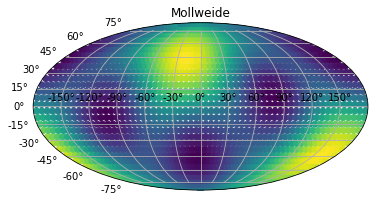

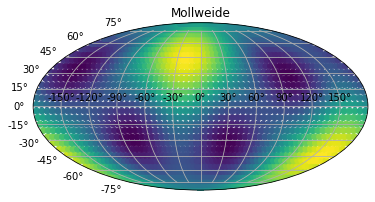

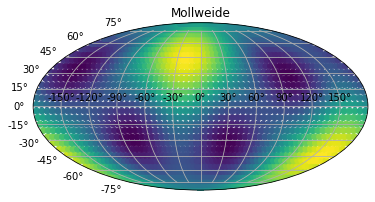

In [89]:
import matplotlib.pyplot as plt

ra, dec = np.meshgrid(np.arange(0, np.pi*2.0, .1), 
                      np.arange(-np.pi / 2.0, np.pi / 2.0, .1))
ra = ra.flatten()
dec = dec.flatten()

pol = 0
time = 1e10
tot=0
totp=0
totc=0
for d in [Detector("E1"), Detector("E2"),Detector("E2")]:
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    tot=tot+fp**2.0 + fc**2.0
    totp=totp+fp
    totc=totc+fc
    plt.figure()
    plt.subplot(111, projection="mollweide")
    ra[ra>np.pi] -= np.pi * 2.0
    plt.scatter(ra, dec, c=fp**2.0 + fc**2.0)
    plt.title("Mollweide")
    plt.grid(True)
    plt.show()


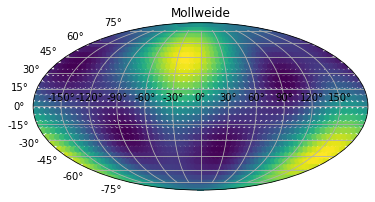

In [90]:
plt.figure()
plt.subplot(111, projection="mollweide")
ra[ra>np.pi] -= np.pi * 2.0
plt.scatter(ra, dec, c=tot)#totp**2+totc**2)
plt.title("Mollweide")
plt.grid(True)
plt.show()